In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint as pp

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error

from fbprophet import Prophet

from lib import utils
from lib import cols
from lib import prophet_utils

In [3]:
# load dateset
df_all_sj, df_all_iq = utils.get_df_all()
df_all_list = [df_all_sj, df_all_iq]

In [4]:
for df in [df_all_sj, df_all_iq]:
    utils.calc_log1p(df)
    

In [5]:
ds_sj, ds_iq = utils.split_data(df_all_sj, df_all_iq)

sj train: 675 lines	 valid: 156 lines	 devtest: 105 lines	 test: 260 lines
iq train: 363 lines	 valid: 104 lines	 devtest: 53 lines	 test: 156 lines
sj valid: 0.19%
iq valid: 0.22%


lib/utils.py:184: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_iq = df_dev_iq[is_train_iq]
lib/utils.py:185: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_valid_iq = df_dev_iq[is_valid_iq]
lib/utils.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_devtest_iq = df_dev_iq[is_devtest_iq]


In [6]:
def train(df, periods):
    m = Prophet().fit(df)
    future = m.make_future_dataframe(periods=periods, freq="d")
    fcst = m.predict(future)
    return m, fcst

def get_score(fcst, df):
    y_pred = np.expm1(fcst[fcst.ds.isin(df.week_start_date)]._yhat.values).round()
    y_truth = df.total_cases.values
    return mean_absolute_error(y_truth, y_pred)

def plot_log_result(fcst, df):
    y_pred = np.expm1(fcst[fcst.ds.isin(df.week_start_date)]._yhat.values)
    df["pred"] = y_pred
    ax = df.plot(x="week_start_date", y="pred")
    df.plot(x="week_start_date", y="total_cases", ax=ax)
    
def plot_result(fcst, df):
    y_pred = fcst[fcst.ds.isin(df.week_start_date)]._yhat.values
    df["pred"] = y_pred
    ax = df.plot(x="week_start_date", y="pred")
    df.plot(x="week_start_date", y="total_cases", ax=ax)

def create_prediction(fcst, df):
    y_pred = np.expm1(fcst[fcst.ds.isin(df.week_start_date)]._yhat.values)    
    return y_pred

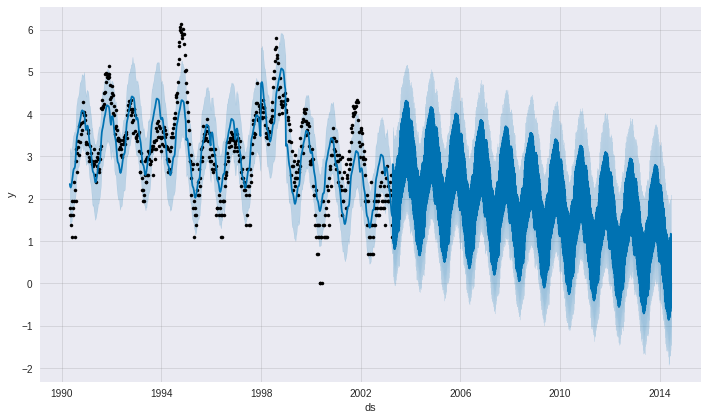

In [7]:
col_target = cols.log1p_target[0]
df_sj = ds_sj.df_train[["week_start_date", col_target]]
df_sj.columns = ["ds", "y"]
period_sj = 7*53*11
m_sj, fcst_sj = train(df_sj, period_sj)
m_sj.plot(fcst_sj);
plt.savefig("./img/prophet_log_sj.svg", bbox_inches='tight')

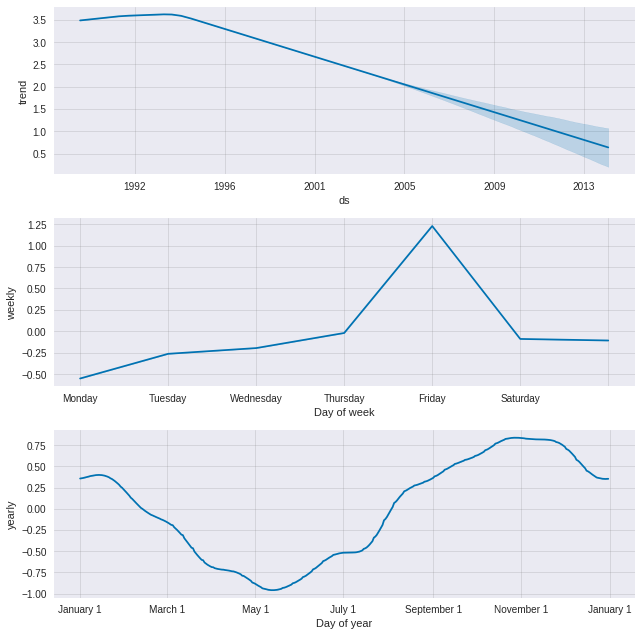

In [8]:
m_sj.plot_components(fcst_sj);
plt.savefig("./img/prophet_log_components_sj.svg", bbox_inches='tight')

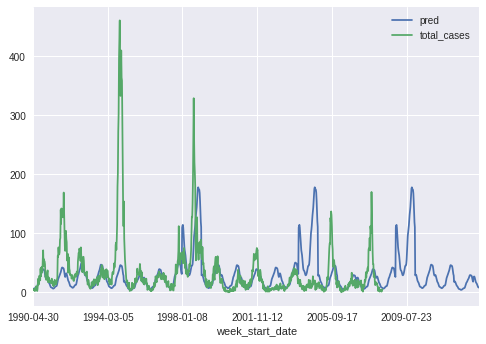

In [9]:
mu = ds_sj.df_train.log1p_total_cases.mean()
fcst_sj["_yhat"] = fcst_sj.seasonal + mu
plot_log_result(fcst_sj, ds_sj.df_all)

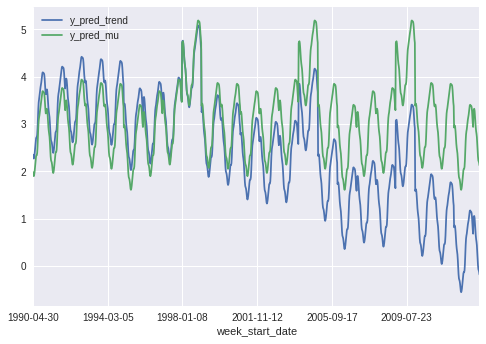

In [10]:
y_pred_trend = fcst_sj[fcst_sj.ds.isin(ds_sj.df_all.week_start_date)].yhat.values
y_pred_mu = fcst_sj[fcst_sj.ds.isin(ds_sj.df_all.week_start_date)]._yhat.values

ds_sj.df_all["y_pred_trend"] = y_pred_trend 
ds_sj.df_all["y_pred_mu"] = y_pred_mu
ax = ds_sj.df_all.plot(x="week_start_date", y="y_pred_trend")
ds_sj.df_all.plot(x="week_start_date", y="y_pred_mu", ax=ax)
plt.savefig("./img/prophet_log_comparison_sj.svg", bbox_inches='tight')

In [11]:
score_valid = get_score(fcst_sj, ds_sj.df_valid)
score_devtest = get_score(fcst_sj, ds_sj.df_devtest)

print(score_valid, score_devtest)

35.7243589744 15.7238095238


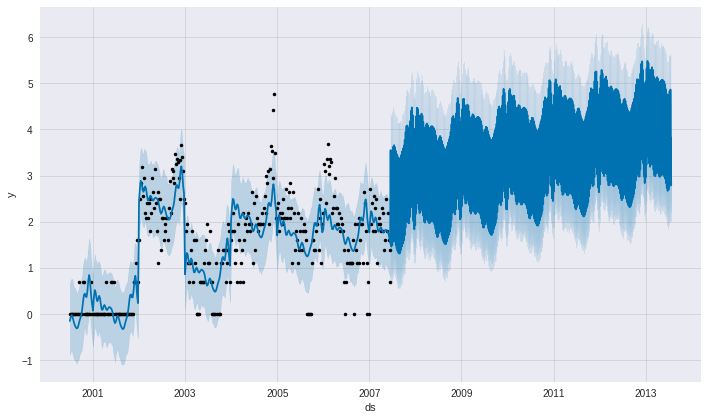

In [12]:
col_target = cols.log1p_target[0]
df_iq = ds_iq.df_train[["week_start_date", col_target]]
df_iq.columns = ["ds", "y"]
period_iq = 7*53*6 # 4 years in days
m_iq, fcst_iq = train(df_iq, period_iq)
m_iq.plot(fcst_iq);
plt.savefig("./img/prophet_log_iq.svg", bbox_inches='tight')

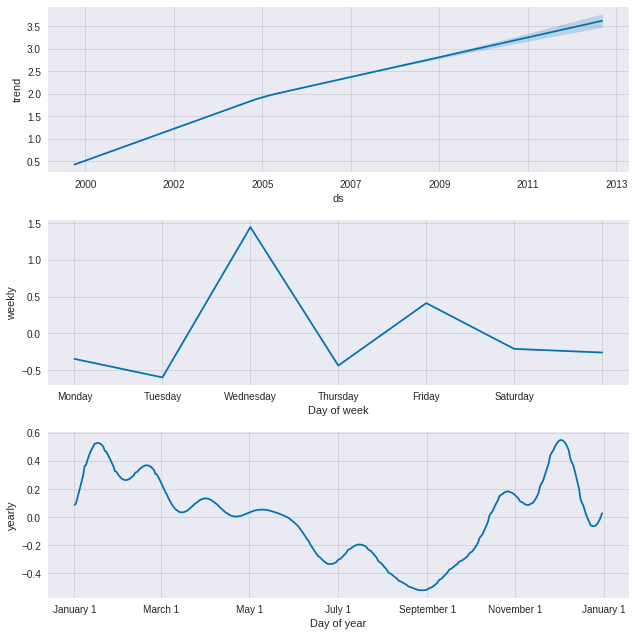

In [13]:
m_iq.plot_components(fcst_iq);
plt.savefig("./img/prophet_log_components_iq.svg", bbox_inches='tight')

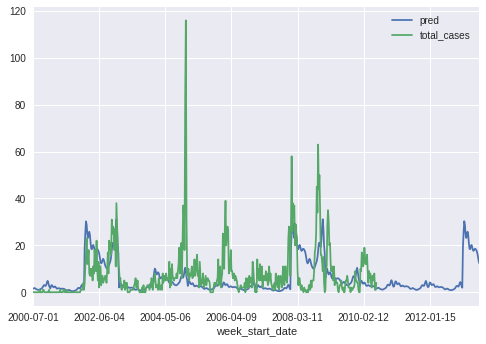

In [14]:
mu = ds_iq.df_train.log1p_total_cases.mean()
fcst_iq["_yhat"] = fcst_iq.seasonal + mu
plot_log_result(fcst_iq, ds_iq.df_all)

In [15]:
score_valid = get_score(fcst_iq, ds_iq.df_valid)
score_devtest = get_score(fcst_iq, ds_iq.df_devtest)

print(score_valid, score_devtest)

9.73076923077 4.50943396226


In [16]:
prophet_utils.save_result(fcst_sj, fcst_iq, ds_sj.df_test, ds_iq.df_test, "prophet")